# Bayesian Optimisation with Pyro

Goal: apply Bayesian Optimisation (BO) strategy from pyro to minimize Branin-Hoo function as the first step towards structured Bayesian Optimisation implementation in pyro.

Based on https://pyro.ai/examples/bo.html

The Branin-Hoo function:

$f(x) = a(x_2 - bx_1^2 + cx_1 - r)^2 + s(1-t)\cos(x_1) + s$

In [1]:
import math
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import numpy as np
import torch
import torch.autograd as autograd
import torch.optim as optim
from torch.distributions import constraints, transform_to

import pyro
import pyro.contrib.gp as gp

assert pyro.__version__.startswith('0.4')
pyro.enable_validation(True)
pyro.set_rng_seed(1)

# Objective function

In [2]:
# Branin Hoo constants
const_a = 1.0
const_b = 5.1 / (4.0 * math.pow(math.pi, 2))
const_c = 5.0 / math.pi
const_r = 6.0
const_s = 10
const_t = 1.0 / (8.0 * math.pi)

const_x1_min = -5
const_x1_max = 10

const_x2_min = 0
const_x2_max = 15

def branin_hoo_first_term(X):
    return const_s * (1.0 - const_t) * torch.cos(X[0]) + const_s

def branin_hoo(X):
    return branin_hoo_first_term(X) + \
        const_a * torch.pow(X[1] - const_b * torch.pow(X[0], 2) + const_c * X[0] - const_r, 2)

# Checking LMs
assert np.allclose(
        branin_hoo(torch.stack((
            torch.tensor([-math.pi, math.pi, 9.42478]), 
            torch.tensor([12.275, 2.275, 2.475])))).numpy(),
        np.array([0.397887, 0.397887, 0.397887], dtype=np.float32), rtol=1e-6)

# Visualisation of the objective function 
Impossible in a real-world setting

In [3]:
steps = 1000
strides = 200

X1 = torch.linspace(const_x1_min, const_x1_max, steps)
X2 = torch.linspace(const_x2_min, const_x2_max, steps)

X1_mesh, X2_mesh = torch.meshgrid(X1, X2)
Z_mesh = branin_hoo(torch.stack((X1_mesh, X2_mesh)))

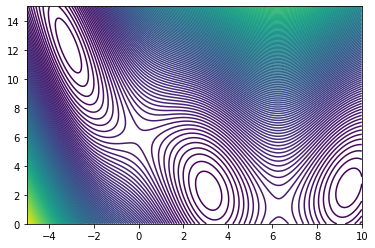

In [4]:
plt.contour(X1_mesh, X2_mesh, Z_mesh, strides)

# Initial (train) data

Generating random (5) training points

In [5]:
train_cnt = 5

X1_train = torch.tensor([x for x in np.random.uniform(low=const_x1_min, high=const_x1_max, size=train_cnt)])
X2_train = torch.tensor([x for x in np.random.uniform(low=const_x2_min, high=const_x2_max, size=train_cnt)])
X_train = torch.stack((X1_train, X2_train))

Y_train = branin_hoo(X_train)


# Gussian Processes as a function for prior

Matern kernel with $\nu=\frac{5}{2}$ is chosen as the kernel. Other pupolar options are: RBF, ...

In [6]:
gpmodel = gp.models.GPRegression(X_train.T, Y_train, 
                                 gp.kernels.Matern52(input_dim=2), 
                                 noise=torch.tensor(0.1), 
                                 jitter=1.0e-4)

# Constructing BO strategy

### Defining acquisition function

Lower Confidence Bound: $\alpha(x)=\mu(x) - \kappa\sigma(x)$

In [7]:
def lower_confidence_bound(x, kappa=2):
    
    mu, variance = gpmodel(x, full_cov=False, noiseless=False)
    sigma = variance.sqrt()
    
    return mu - kappa * sigma

def acquisition_func(x):
    return lower_confidence_bound(x)

### Function to find minimizing points for an acquisition function

In [8]:
def find_a_candidate(x_init):
    
    # Creating constrains
    constraint_x1 = constraints.interval(const_x1_min, const_x1_max)
    constraint_x2 = constraints.interval(const_x2_min, const_x2_max)
    
    # transform x_init to an unconstrained domain as we use an unconstrained optimizer
    unconstrained_x1_init = transform_to(constraint_x1).inv(x_init[:, 0])
    unconstrained_x2_init = transform_to(constraint_x2).inv(x_init[:, 1])
    x_uncon_init = torch.stack((unconstrained_x1_init, unconstrained_x2_init), dim=1)
    
    x_uncon = x_uncon_init.clone().detach().requires_grad_(True)
    
    # unconstrained minimiser
    minimizer = optim.LBFGS([x_uncon])

    def closure():
        minimizer.zero_grad()
                
        x1_tmp = transform_to(constraint_x1)(x_uncon[:, 0])
        x2_tmp = transform_to(constraint_x2)(x_uncon[:, 1])
        x = torch.stack((x1_tmp, x2_tmp), dim=1)
        
        y = acquisition_func(x)
        
        autograd.backward(x_uncon, autograd.grad(y, x_uncon))
                
        return y
    
    minimizer.step(closure)
   
    # after finding a candidate in the unconstrained domain,
    # convert it back to original domain.
    x1_tmp = transform_to(constraint_x1)(x_uncon[:, 0])
    x2_tmp = transform_to(constraint_x2)(x_uncon[:, 1])
    
    x = torch.stack((x1_tmp, x2_tmp), dim=1)
    
    return x.detach()

### A single step of BO

LBFGS optimiser used in `find_a_candidate` is a gradient based method and can get stuck at a local minimum. A simple approach to address this is to try several attemps (5) to find the best candidate to minimize the acquisition function.

In [9]:
def next_x(num_candidates=5):
    
    candidates = []
    values = []
    
    # take the last point as the first attempt
    x_init = gpmodel.X[-1:]
    
    for i in range(num_candidates):
        
        x = find_a_candidate(x_init)
        y = acquisition_func(x)
    
        candidates.append(x)
        values.append(y)
        
        # a new random attempt initial point
        x_init = torch.stack((
                x[:,0].new_empty(1).uniform_(const_x1_min, const_x1_max),
                x[:,1].new_empty(1).uniform_(const_x2_min, const_x2_max)), dim=1)
        
    argmin = torch.min(torch.cat(values), dim=0)[1].item()
    
    return candidates[argmin]

# Updating posterior

Each time we evaluate `f` at a new value x, we update the `gpmodel`.

In [10]:
def update_posterior(x_new):
    
    # evaluate f at new point
    bh_y = branin_hoo(x_new.T) 
    
    # incorporate new evaluation
    X = torch.cat([gpmodel.X, x_new]) 
    y = torch.cat([gpmodel.y, bh_y])
    
    gpmodel.set_data(X, y)
    
    # optimize the GP hyperparameters using Adam with lr=0.001
    optimizer = torch.optim.Adam(gpmodel.parameters(), lr=0.001)
    
    gp.util.train(gpmodel, optimizer) 

# The BO Algorithm (minimalistic)

In [11]:
bo_steps = 10

optimizer = torch.optim.Adam(gpmodel.parameters(), lr=0.001)
gp.util.train(gpmodel, optimizer)

for i in range(bo_steps):
    xmin = next_x()
    update_posterior(xmin)    

# Comparing objective function vs GP model

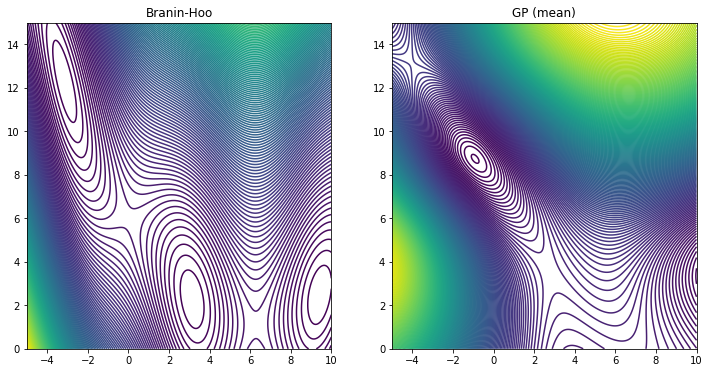

In [12]:
fig, ax = plt.subplots(figsize=(12, 6), ncols=2, nrows=1)
ax[0].contour(X1_mesh, X2_mesh, Z_mesh, strides)
ax[0].title.set_text('Branin-Hoo')

predict_mesh, _ = gpmodel(torch.stack((X1_mesh.flatten(), X2_mesh.flatten())).T)
ax[1].contour(X1_mesh, X2_mesh, predict_mesh.reshape((steps, steps)).detach(), strides)
ax[1].title.set_text('GP (mean)')

# Visualising BO x points

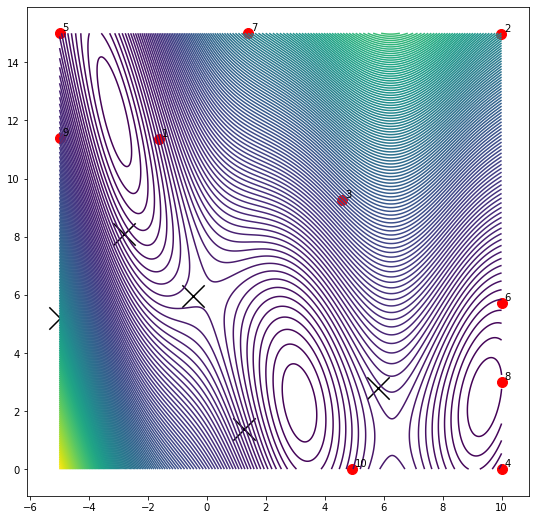

In [13]:
def add_points(bo_ax, gpmodel_, train_cnt):
    
    # Plotting training data
    bo_ax.scatter(
        gpmodel_.X.numpy().T[0][:train_cnt], 
        gpmodel_.X.numpy().T[1][:train_cnt],
        marker="x", s=500, c='black')

    # Plotting BO steps
    bo_ax.scatter(
        gpmodel_.X.numpy().T[0][train_cnt:], 
        gpmodel_.X.numpy().T[1][train_cnt:],
        marker="o", s=100, c='red')

    for i, iter in enumerate(gpmodel_.X.numpy()):
        if i >= train_cnt:
            bo_ax.annotate("%d" % (i+1-train_cnt), 
                        (iter.T[0] + 0.1, iter.T[1] + 0.1))

fig, ax = plt.subplots(figsize=(9, 9))
CS = ax.contour(X1_mesh, X2_mesh, Z_mesh, strides)

add_points(ax, gpmodel, train_cnt)

# Visualising BO Algorithm

In [ ]:
# bo_steps = 10
# no_cols = 3

# fbo, fbo_axes = plt.subplots(ncols=no_cols, nrows=bo_steps, figsize=(no_cols*6, bo_steps*6))

# optimizer = torch.optim.Adam(gpmodel.parameters(), lr=0.001)
# gp.util.train(gpmodel, optimizer)

# for i in range(bo_steps):

#     xmin = next_x()
    
#     ########### Ploting prior
#     Predict_mesh, _ = gpmodel(torch.stack((X1_mesh.flatten(), X2_mesh.flatten())).T) 

#     Predict_mesh = Predict_mesh.reshape((steps, steps)).detach()
#     fbo_axes[i, 0].contour(X1_mesh, X2_mesh, Predict_mesh, strides)
#     fbo_axes[i, 0].title.set_text('Step %d: prior' % (i+1))
    
#     ########### Plotting acquisition function
#     acquisition_mesh = acquisition_func(
#             torch.stack((X1_mesh.flatten(), X2_mesh.flatten())).T)
    
#     acquisition_mesh = acquisition_mesh.reshape((steps, steps)).detach()
#     fbo_axes[i, 1].contour(X1_mesh, X2_mesh, acquisition_mesh, strides)
    
#     # Updating posterior
#     update_posterior(xmin)
            
#     ########### Plotting GP countour plot
#     Predict_mesh, _ = gpmodel(torch.stack((X1_mesh.flatten(), X2_mesh.flatten())).T) 

#     Predict_mesh = Predict_mesh.reshape((steps, steps)).detach()
#     fbo_axes[i, 2].contour(X1_mesh, X2_mesh, Predict_mesh, strides)
#     fbo_axes[i, 2].title.set_text('Step %d: posterior' % (i+1))
    
#     fbo_axes[i, 1].scatter(
#         gpmodel.X.numpy().T[0][len(gpmodel.X.numpy())-1], 
#         gpmodel.X.numpy().T[1][len(gpmodel.X.numpy())-1],
#         marker="o", s=100, c='red')
    
#     fbo_axes[i, 1].title.set_text('Step %d: acquisition function' % (i+1))
        